This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [106]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [107]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x193e4d33450>)

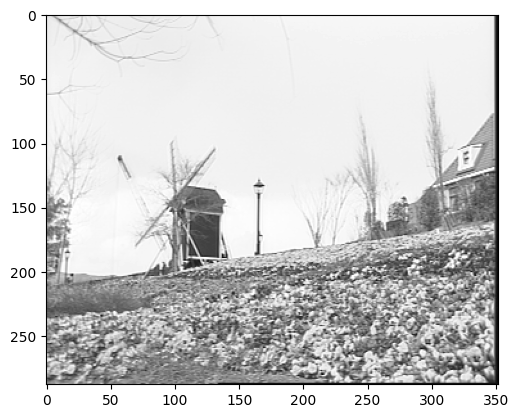

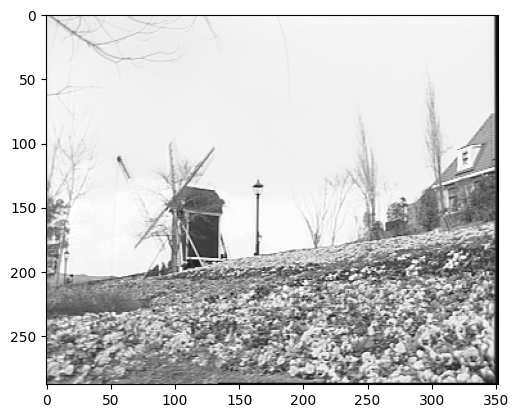

In [108]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [109]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius
lamb = 0 # regularization parameter

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [110]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for r in range(0,cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0,cur.shape[1],bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block

                # Initialization:
                bestV = [0,0]
                costMin = np.inf
                
                Rbest = np.zeros((brow,bcol))
                
                # Loop on candidate displacement vectors
                for dcol in range(-extension,extension): # dcol = candidate displacement vector over the columns
                    for drow in range(-extension,extension):# drow = candidate displacement vector over the rows
                        A = ref_extended[r+drow+extension:r+drow+extension+brow,c+dcol+extension:c+dcol+extension+bcol]
                        cost = np.sum((B-A)**2)
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = A
                            bestV = [drow,dcol]
    
                mvf[r:r+brow,c:c+bcol,0] = bestV[0]*np.ones((brow,bcol)) # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = bestV[1]*np.ones((brow,bcol))# Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                   
    else: # Regularized search
        for r in range(0,cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0,cur.shape[1],bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block

                # Initialization:
                bestV = [0,0]
                costMin = np.inf
                
                Rbest = np.zeros((brow,bcol))

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate displacement vectors
                for dcol in range(-extension,extension): # dcol = candidate displacement vector over the columns
                    for drow in range(-extension,extension):# drow = candidate displacement vector over the rows
                        A = ref_extended[r+drow+extension:r+drow+extension+brow,c+dcol+extension:c+dcol+extension+bcol]
                        cost = np.sum((B-A)**2)+lamb*np.linalg.norm(pV-np.array([drow,dcol])) # here, encore the REGULARIZED cost function
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = A
                            bestV = [drow,dcol]
    
                mvf[r:r+brow,c:c+bcol,0] = bestV[0]*np.ones((brow,bcol)) # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = bestV[1]*np.ones((brow,bcol))# Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                
                
    mvf = -mvf # For compatibility with standards
                               
    return mvf, prediction

In [111]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius,lamb)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

#### Answer: 
The vector field is pretty much like we expected it to be. We can see that the windmill is rotating since the vector field does the same. However, there are some pretty big displacement vectors in the sky which is supposed to be a static region. Regularization is going to help us solve this problem.\
\
Increasing the search size allows bigger displacement vectors to appear but also reduces the apparent size of vectors in the zone of interest, ie around the windmill. CHanging the ize of the blocs allows us to be more or less precise on the direction of the movement of the bloc at the cost of computational time: bigger blocs can have a direction that seems counterintuitive but are faster to compute.

In [112]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

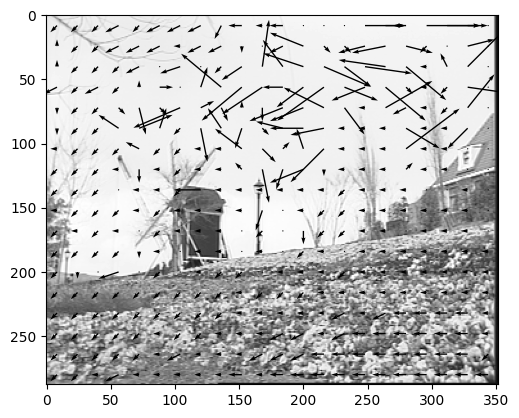

In [113]:
displayMVF(im1,mvf_ssd,brow)

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

#### Answer:
The motion compensated image is pretty much the same image as the first frame. Indeed the most important displacement vectors are in the sky, we can't see their effects and they are at most 8 pixels long. The effects can however be seen on the lamp in the bottom left which appears a bit wider.

In [114]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x193d79e0e50>)

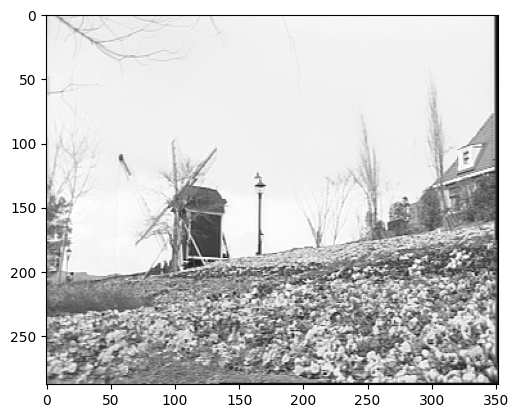

In [115]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

#### Answer:
$PSNR = 10log(\frac {255²}{MSE})$ because the max value of pixels in a 8-bit image is 255.\
The PSNR between the motion compensated image and im2 (16.46) is lower than the one between im1 and im2 (18.79). It should be the opposite because the compensated image is supposed to be closer to im1 than im2. It can however be explained by the lack of regularization which allows the compensated image to move too much which creates more noise.\
Increasing the block size from 16 to 32 pixels reduces the PSNR to 16.35, reducing the block size to 8 pixels puts the PSNR to 16.41. Reducing the search radius increases the PSNR to 16.47 and increasing it reduces the PSNR by about $\frac 1 {1000}$. This seems logical: searching less far makes the algorithm more precise and the opposite allows more radical changes that cause a smaller PSNR. As for why changing the block size only lowers the PSNR, it seems weird, I would have thought that only increasing it would have done so because the movement of a block would be less representative of all the objects inside. Smaller blocks should make the algorithm more precise.

In [116]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    mse = np.mean((im1-im2)**2)
    if mse == 0:
        psnr = np.inf
    else:
        psnr = 10*np.log10(255*255/mse)
    return psnr

In [117]:
psnr_ssd = PSNR(im2,mc_ssd)
print("PSNR between im2 and compensated im2:",psnr_ssd)
print("PSNR between im1 and im2:",PSNR(im1,im2))

PSNR between im2 and compensated im2: 16.460078862210647
PSNR between im1 and im2: 18.786509322935075


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [118]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    
    # Non-regularized search
    if lamb == 0.:
        for r in range(0,cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0,cur.shape[1],bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block

                # Initialization:
                bestV = [0,0]
                costMin = np.inf
                
                Rbest = np.zeros((brow,bcol))
                
                # Loop on candidate displacement vectors
                for dcol in range(-extension,extension): # dcol = candidate displacement vector over the columns
                    for drow in range(-extension,extension):# drow = candidate displacement vector over the rows
                        A = ref_extended[r+drow+extension:r+drow+extension+brow,c+dcol+extension:c+dcol+extension+bcol]
                        cost = np.sum(np.abs(B-A))
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = A
                            bestV = [drow,dcol]
    
                mvf[r:r+brow,c:c+bcol,0] = bestV[0]*np.ones((brow,bcol)) # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = bestV[1]*np.ones((brow,bcol))# Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                
    else: # Regularized search
        for r in range(0,cur.shape[0],brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0,cur.shape[1],bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block

                # Initialization:
                bestV = [0,0]
                costMin = np.inf
                
                Rbest = np.zeros((brow,bcol))

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate displacement vectors
                for dcol in range(-extension,extension): # dcol = candidate displacement vector over the columns
                    for drow in range(-extension,extension):# drow = candidate displacement vector over the rows
                        A = ref_extended[r+drow+extension:r+drow+extension+brow,c+dcol+extension:c+dcol+extension+bcol]
                        cost = np.sum(np.abs(B-A))+lamb*np.linalg.norm(pV-np.array([drow,dcol])) # here, encore the REGULARIZED cost function
                        
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = A
                            bestV = [drow,dcol]
    
                mvf[r:r+brow,c:c+bcol,0] = bestV[0]*np.ones((brow,bcol)) # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = bestV[1]*np.ones((brow,bcol))# Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [119]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius, lamb)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

#### Answer:
The vector field seems to be a bit more regular than the SSD one and it looks like there are less outliers but only a small amount. This is due to the fact that using the absolute value instead of the square fosters the null costs instead of the really low ones. However there are few differences because there is not regularization yet.

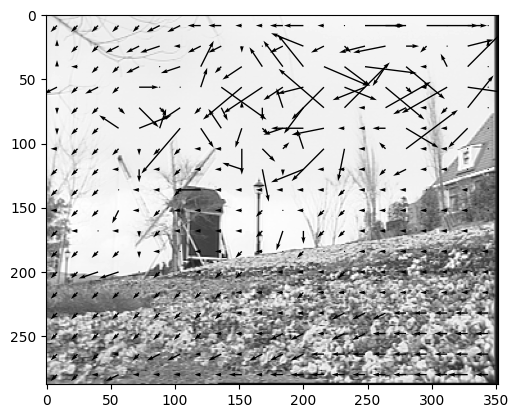

In [120]:
displayMVF(im1,mvf_sad,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

#### Answer:
The SAD motion vector field looks a bit more regular than the SSD one. This first metric also yields a lower PSNR, 16.399 instead of 16.46. If the block size is lowered the PSNR goes to 16.3950109 and increasing the block size to 32 pixels lowers it to 16.331. We can conclude that block size has pretty much no effect on the PSNR for the SAD method and we get the same weird lowering of the PSNR as with SSD.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x193e6344550>)

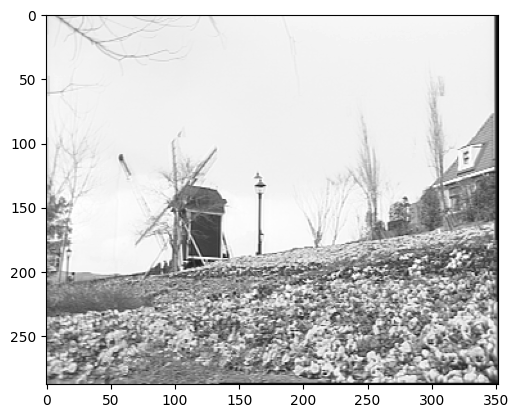

In [121]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [122]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

16.39966244983968


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

#### Answer:
What we just did is add a second term to the cost: $\lambda ||[u,v]-pV||_2$ where $[u,v]$ is the displacement vector and pV is the median of the motion vector field of three neighboring blocks.\
Regularization made the PSNR between im2 and the motion compensated image higher than the PSNR between im1 and im2 which validates the use of regularization, we now have an image that is closer to the image we want to reach. We get the following values of PSNR for different values fo $\lambda$ :
- $\lambda$ = 0 : 16.46 (unregularized)
- $\lambda$ = 1 : 16.47
- $\lambda$ = 10 : 16.47
- $\lambda$ = 100 : 16.47
- $\lambda$ = 100000 : 21.14

The regularization produces a better result but $\lambda$ needs to be very high for it to have a real effect.

### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

#### Answer:
For different values of $\lambda$ we get the following PSNR values:
- $\lambda$ = 0 : 16.40 (unregularized)
- $\lambda$ = 1 : 16.43
- $\lambda$ = 10 : 17.60
- $\lambda$ = 100 : 21.14
- $\lambda$ =100000 : 21.14

In this case, the regularization has an impact on the result even with low values of $\lambda$ and we get to the "limit" value of 21.14 much quicker which proves that SAD is a better way of motion compensating than SSD.

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [123]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x193e62ea2d0>)

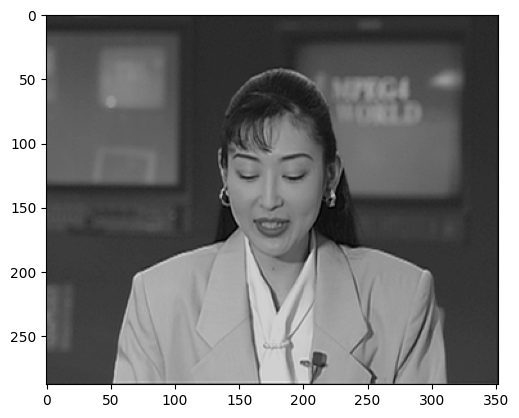

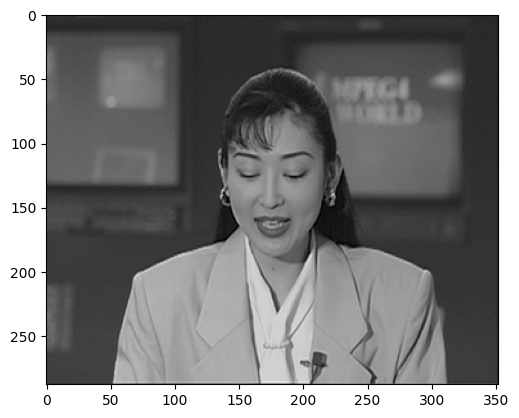

In [124]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [125]:
brow = 16; bcol=16; search_radius =13;

In [126]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg=convolve2d(u,kernel_1,'same')
        vAvg=convolve2d(v,kernel_1,'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg-fx*((uAvg*fx+vAvg*fy+ft)/(alpha**2+fx**2+fy**2))
        v = vAvg-fy*((uAvg*fx+vAvg*fy+ft)/(alpha**2+fx**2+fy**2))
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [127]:
alpha = 100
ite = 100

mfv_ssd, prediction = me_ssd(im2,im1,brow,bcol,search_radius)

uInitial = mvf_ssd[:,:,1] # Rem: pay attention to the inversion of the order compare to me_ssd.
vInitial = mvf_ssd[:,:,0]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

#### Answer:
The vector field is weirdly not null in the background where there shouldn't be any movement and the mouth which clearly has moved between the two images doesn't contain notable vectors. However when looking at the eyes which seem to close a bit there are a lot of non null vectors in this area. Finally, the PSNR reaches 32.96 which means this method, while a bit slower than block matching because each block is a pixel, is better.

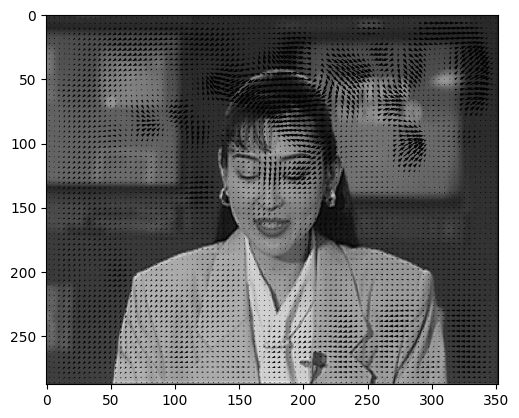

In [128]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [129]:
psnr_hs

32.95616648826456